### Imports

In [1]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [2]:
!pip show tensorflow # Should be v2.10

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras # Should be v2.10

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)
reload(generators)

<module 'helpers.generators' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\generators.py'>

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
NUM_FOLDS = 3
NUM_EPOCHS = 1
DATA_BATCH_SIZE = 32
GPU_BATCH_SIZE = 16

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="../data/DATASET_CSVS/deepship_5k_seg_3s.csv",
    new_path_to_root="../data/deepship_baseline_unnorm_mat",
    ext="mat", 
    n_folds=NUM_FOLDS,
    unix=False
)

In [8]:
train_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=0, val_idx=None)

print(train_df.shape)
print(test_df.shape)

del fold_dfs

(10839, 5)
(4534, 5)


In [9]:
train_gen = generators.DeepShipGenerator(
    df=train_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

test_gen = generators.DeepShipGenerator(
    df=test_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

### Initialise model

In [10]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [11]:
from models import irfan_2020
reload(irfan_2020)

irfan = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))

irfan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

irfan.summary()

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

### Train model

In [12]:
# 10 folds, 2 epochs ~ 13min
# 10 folds, 10 epochs ~ 60 min

history = irfan.fit(
    train_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2
)

338/338 - 92s - loss: 0.0219 - psnr: 17.0769 - 92s/epoch - 272ms/step


In [13]:
evals = irfan.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

141/141 - 13s - loss: 0.0307 - psnr: 15.3502 - 13s/epoch - 93ms/step


In [14]:
irfan.save("models/saved/irfan_denoiser_03122024/irfan_denoiser.keras")

### Evaluation, metrics, and visualising denoised output

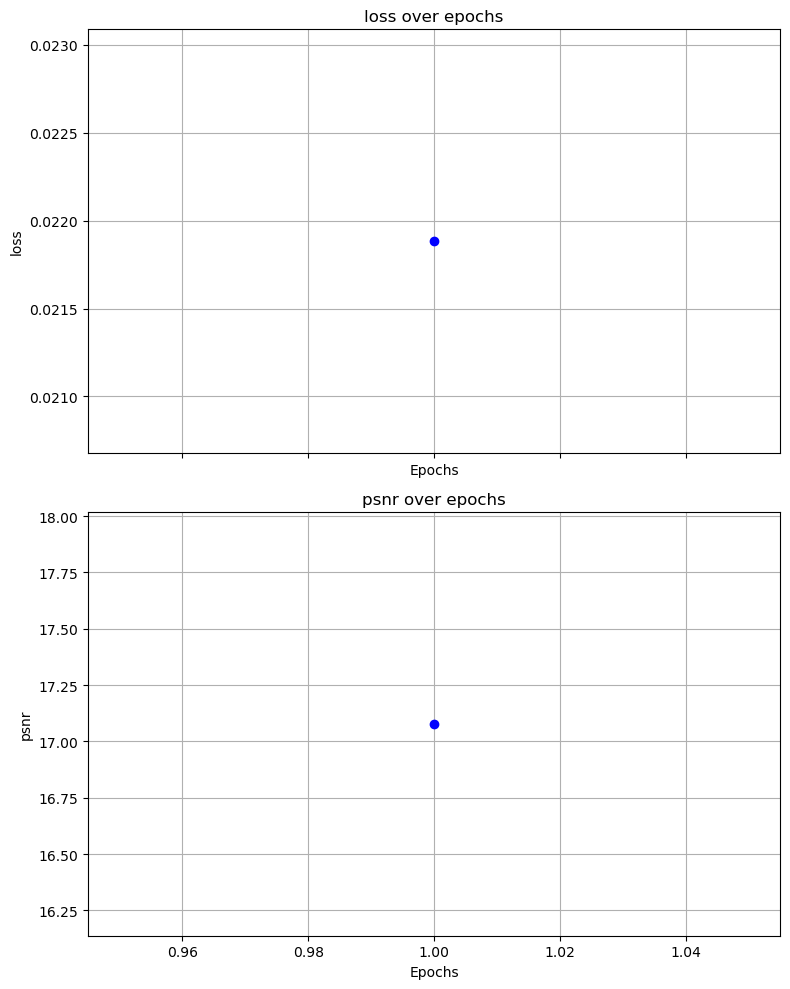

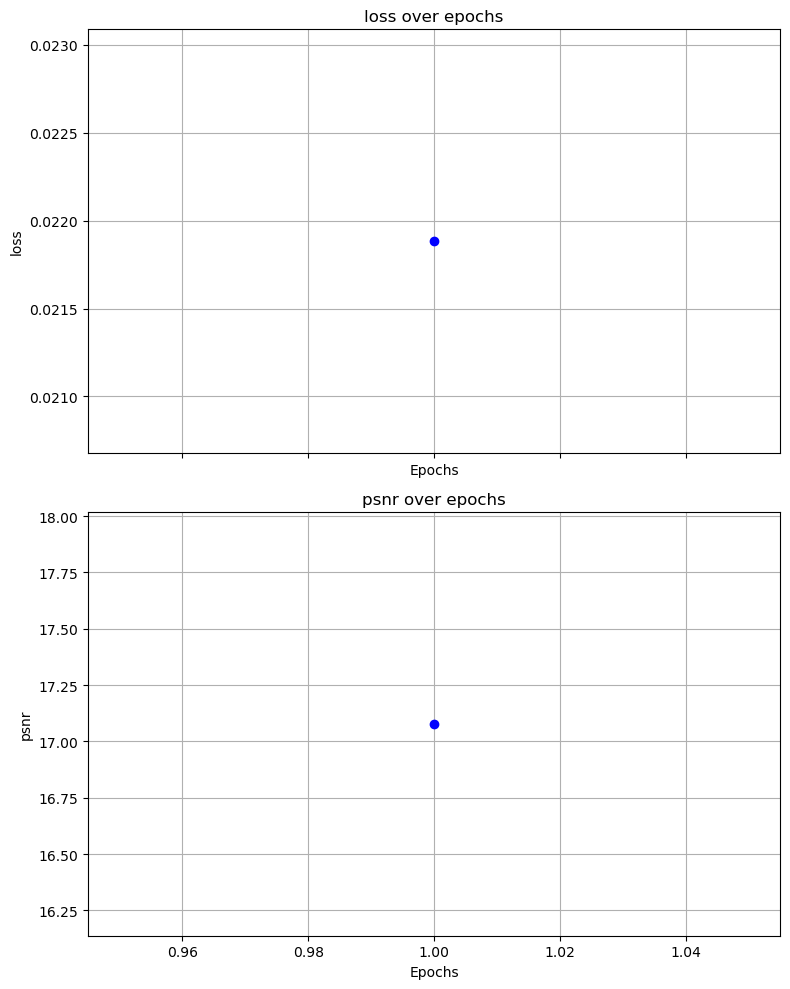

In [15]:
utils.get_history_curve(history, metrics=['loss', 'psnr'])

In [16]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = irfan.predict(sample_inputs)

1/1 [==============================] - 1s 750ms/step


In [17]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.03000587970018387
PSNR on sample batch: [13.166018 17.130566 14.924206 15.273318 16.870771]


In [18]:
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.2124415934085846; Max: 0.7576305866241455
Sample 2 - Min: 0.273991197347641; Max: 0.7487598061561584
Sample 3 - Min: 0.25706416368484497; Max: 0.7483304738998413
Sample 4 - Min: 0.26596179604530334; Max: 0.7493221759796143
Sample 5 - Min: 0.26382723450660706; Max: 0.7581380605697632


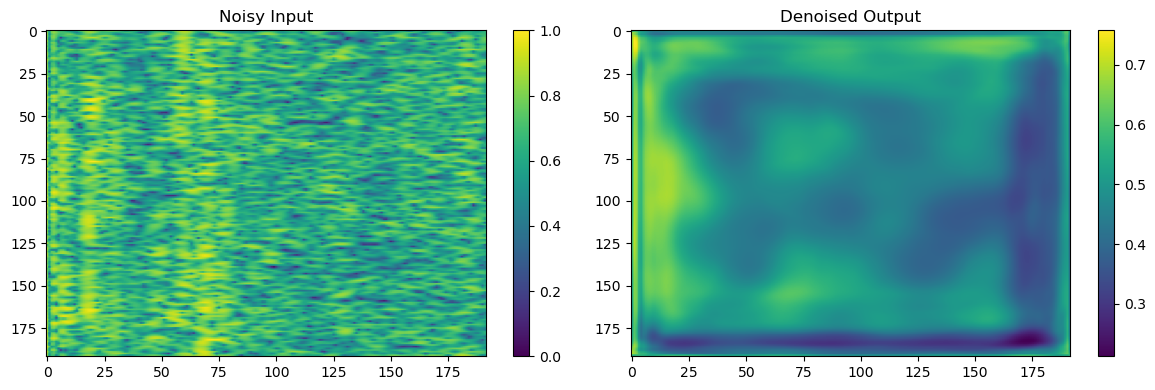

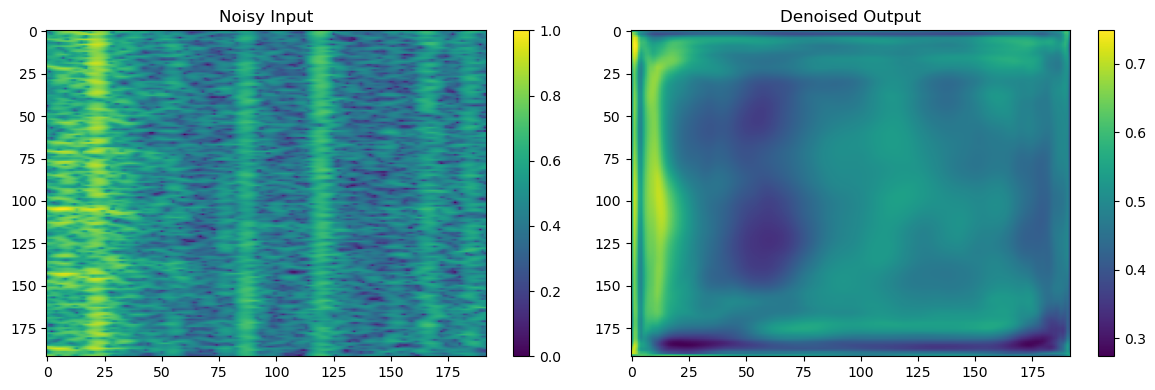

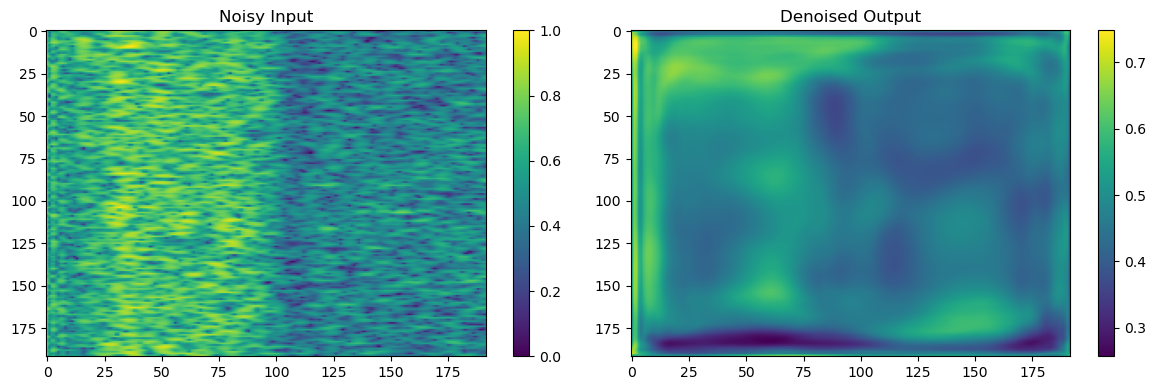

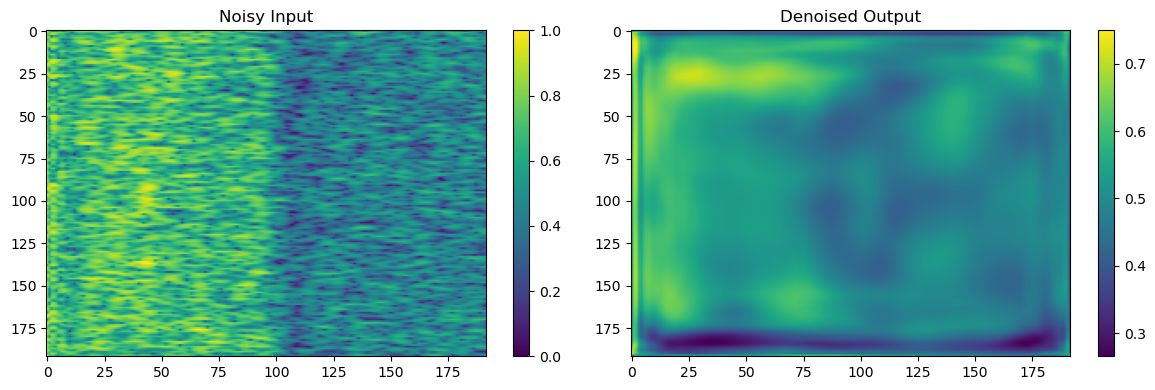

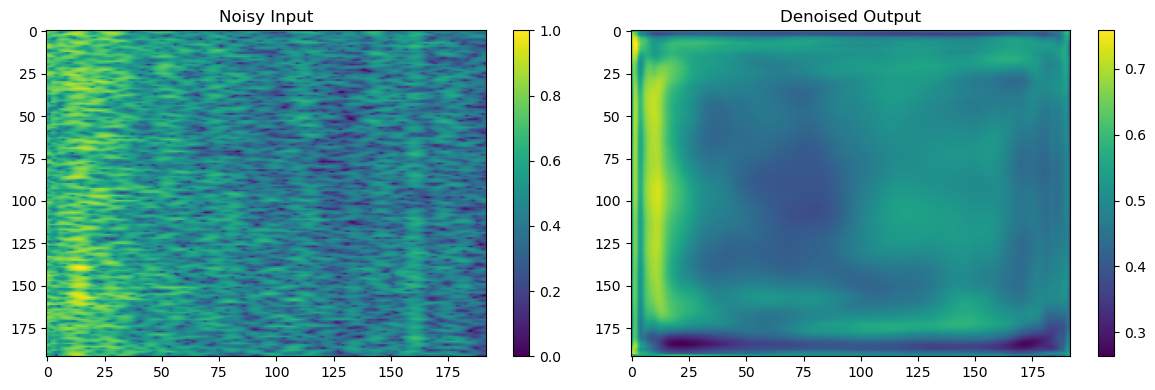

In [19]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input")
    plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # fig.savefig(f"models/img/irfan_denoise/ex{i + 1}.png")